In [1]:
from numpy import zeros, sqrt, linalg, loadtxt,array, ones, exp, eye, copy,sign,real,imag,transpose,log,average,sort, var, conj, math, var,append, save,argsort, delete
from numpy.linalg import inv
import matplotlib.pyplot as plt
from random import randint, random, gauss
from scipy.sparse import lil_matrix
from scipy.optimize import basinhopping, dual_annealing, shgo, direct, brute, differential_evolution, minimize
from scipy.sparse.linalg import eigsh
import time
import numpy as np

def loadData(N,rho,U,V):
    phi = loadtxt("Ns%i_N%i_J%f_U%f_V%f"%(round(N/rho),N,1,U,V))
    phi /= sqrt(sum(sum(abs(phi)**2)))
    return phi

N=4
Ns=20
U=40
V=-1.97
phi = loadData(N,N/Ns,U,V)
phiR = loadData(N+1,(N+1)/Ns,U,V)

In [2]:
#here we try to estimate 5 atomic function based on 4 atomic correlator. We load data for 4 atoms, compute G4 and F4

basis = []
basisXXp = []
G4 = []
F4 = []

def getG4(xs):
    xs_ = np.copy(xs)
    xs_ = sort(xs_)

    index = basis.index(Ns**3*xs_[0]+Ns**2*xs_[1]+Ns*xs_[2]+xs_[3])
    return G4[index]

def getF4(xs):
   # print(array(sort(xs)))
    xs_ = np.copy(xs)
    xs_ = sort(xs_)

    index = basis.index(Ns**3*xs_[0]+Ns**2*xs_[1]+Ns*xs_[2]+xs_[3])
    return F4[index]

def computeG4(xs):
    out = 0
    for xNew in range(0,Ns): 
        xs_ = [x for x in xs]+[xNew]
        tmp = 1.0
        for i in range(0,N+1):
            for j in range(i+1,N+1):
                tmp *= abs(phi[xs_[i],xs_[j]])**2
        out +=tmp
    return out

def psi5(xs):
    out = 1
    for i in range(0,len(xs)):
        for j in range(i+1,len(xs)):
            out *= phi[xs[i],xs[j]]
    return out
            

def computeF4(xs):
    out = 0.0
    for x4 in range(0,Ns):
        for x5 in range(0,Ns):
            out += psi5([xs[0],xs[2],xs[3],x4,x5])*psi5([xs[1],xs[2],xs[3],x4,x5])
    return out

for x1 in range(0,Ns):
    for x2 in range(x1,Ns):
        basisXXp.append([x1,x2])
        for x3 in range(x2,Ns):
            for x4 in range(x3,Ns):
                basis.append(Ns**3*x1+Ns**2*x2+Ns*x3+x4)
                G4.append(computeG4([x1,x2,x3,x4]))
                F4.append(computeF4([x1,x2,x3,x4]))

def delta(x,xp):
    if x==xp:
        return 1
    return 0
          
WK = []
WU = []
WV = []
for [x,xp] in basisXXp:
    elemWK = 0
    elemWU = 0
    elemWV = 0
    for x3 in range(0,Ns):
        for x4 in range(0,Ns):
            elemWK += (N-1)*(delta(x+1,x2)+delta(x2+1,xp)+2*(N-2)*delta(x2+1,x3))*getF4([x,xp,x3,x4])
            elemWU += (delta(x,xp)+(N-2)*(delta(x,x3)+delta(xp,x3)+(N-3)*delta(x3,x4)))*getG4([x,xp,x3,x4])
            elemWV += (delta(x+1,xp)+(N-2)*(delta(x+1,x3)+delta(xp,x3+1)+(N-3)*delta(x3+1,x4)))*getG4([x,xp,x3,x4])
    WK.append(-2*elemWK)
    WU.append(U*elemWU)
    WV.append(2*V*elemWV)
    

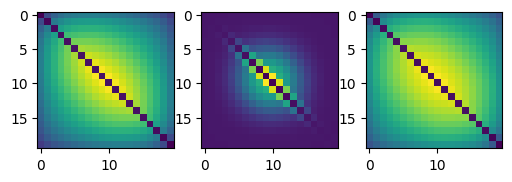

In [3]:
W = array(WK)+array(WU)+array(WV)
W /= sqrt(sum(abs(W)**2))
#print(len(basisXXp))
#print(W)  

def transform1Dto2D(func1D):
    out = np.zeros([Ns,Ns])
    it = 0
    for x in range(0,Ns):
        for xp in range(x,Ns):
            out[x,xp] = func1D[it]
            out[xp,x] = func1D[it]
            it+=1
    return out
        
    
#plt.plot(W)
fig, ax = plt.subplots(1,3,figsize=[6,12])

ax[0].imshow(phi)
ax[1].imshow(abs(transform1Dto2D(W)-1))
ax[2].imshow(phiR)

In [4]:
# def getP(xs):
#     out = 1
#     for i in range(N):
#         for j in range(i+1,N):
#             out *= abs(phi[xs[i],xs[j]])**2
#     return out

# def getN(xs):
#     out = zeros(Ns)
#     for x in xs:
#         out[x]+=1
#     return out

# def numOfAt(pos, xs):
#     out = 0
#     for x in xs:
#         if x==pos:
#             out +=1
#     return out

# def getG2(xs):
#     out = zeros((Ns,Ns))
#     for x in xs:
#         for xp in xs:
#             if x ==xp:
#                 out[x,xp]+=(numOfAt(x,xs)-1)*numOfAt(xp,xs)
#             else:
#                 out[x,xp]+=numOfAt(x,xs)*numOfAt(xp,xs)
#     return out

# def randNewXs(xsOld):
#     xsNew = xsOld.copy()
#     for n in range(N):
#         #jump = randint(-4, 4)
#         jump = int(gauss(mu=0, sigma=2.1))
#         xsNew[n] =xsNew[n]-jump
#         if xsNew[n]>=Ns:
#             xsNew[n]-=Ns
#         elif xsNew[n]<0:
#             xsNew[n]+=Ns
#     return xsNew

In [5]:
Ns=20       
    
NisR = zeros(Ns)
G2sR = zeros([Ns,Ns])

for i1 in range(Ns):
    for i2 in range(Ns):
        for i3 in range(Ns):
            for i4 in range(Ns):
                NisR += getN([i1,i2,i3,i4])*getP([i1,i2,i3,i4])
                G2sR += getG2([i1,i2,i3,i4])*getP([i1,i2,i3,i4])
NisR /= sum(NisR)*N
G2sR /= sum(sum(G2sR))*N*(N-1)  

NameError: name 'getN' is not defined

In [130]:
Nis = zeros(Ns)
G2s = zeros([Ns,Ns])
time0 = time.time()
xs = np.random.randint(0,Ns-1,N)

t=0
while t < 500000:
    Pold = getP(xs)
    xsNew = randNewXs(xs)
    Pnew = getP(xsNew)
  #  A = min(1,Pnew/Pold)
    if random() <= min(1,Pnew/Pold):
        xs = xsNew
    Nis += getN(xs)
    G2s += getG2(xs)
    t+=1
G2s /= sum(sum(G2s))*N*(N-1)    
Nis /= sum(Nis)*N
print("DONE in",round((time.time()-time0)*1000),"[ms]")

DONE in 13403 [ms]


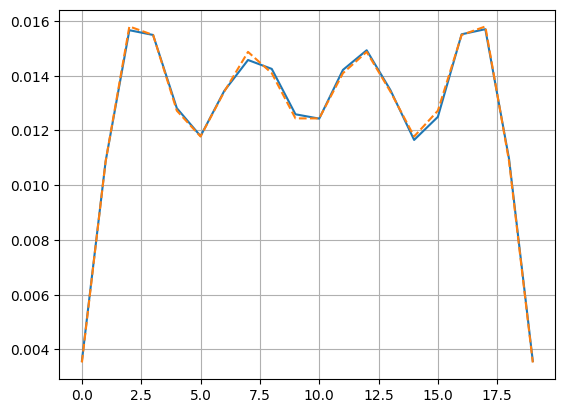

In [128]:
plt.plot(Nis)
plt.plot(NisR,'--')
plt.grid()
plt.show()

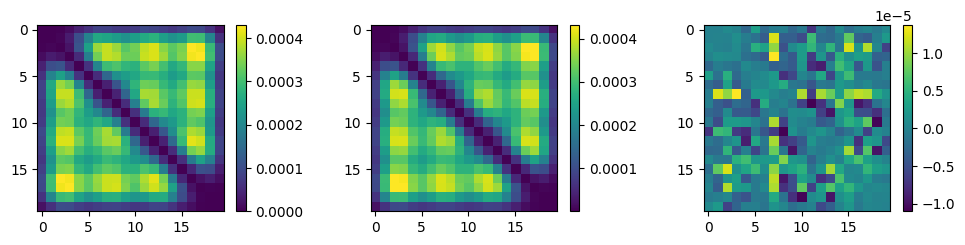

In [129]:
fig, ax = plt.subplots(1,3,figsize=[10,2.5])
pos = ax[0].imshow(G2s)
fig.colorbar(pos, ax=ax[0])
pos = ax[1].imshow(G2sR)
fig.colorbar(pos, ax=ax[1])
pos = ax[2].imshow(G2sR-G2s)
fig.colorbar(pos, ax=ax[2])

plt.tight_layout()
plt.show()

-6
